Training on cpu


  1%|██▏                                                                                                                                            | 14/938 [00:17<19:29,  1.27s/it]


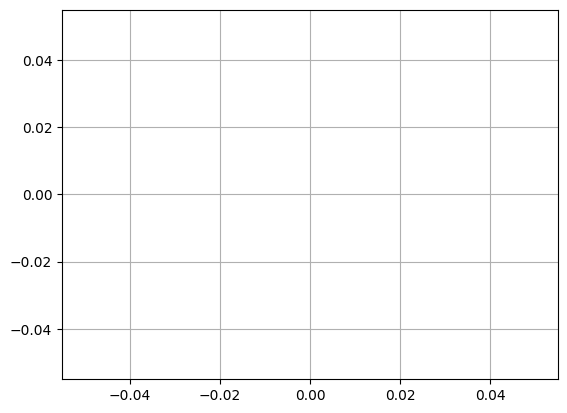

current best accuracy: 90
running time: 0.30104509989420575 mins


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from datetime import datetime
import torchvision.models as models
from tqdm import tqdm
import time

seed = 256

torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on", device)

batch = 64
# Store separate training and validations splits in ./data
training_set = torchvision.datasets.MNIST('./data',download=True,train=True,transform=transforms.ToTensor())
validation_set = torchvision.datasets.MNIST('./data',download=True,train=False,transform=transforms.ToTensor())

training_loader = torch.utils.data.DataLoader(training_set,batch_size=batch,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set,batch_size=100,shuffle=True)

model = models.resnet34(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
timestamp = datetime.now().strftime('%Y%m%d')
# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9, nesterov=True)


NUM_EPOCHS = 200
acc = []
losses = []
best_acc = 90
# Train the model

T = time.time()
try:
  for epoch in range(NUM_EPOCHS):
      # Train the model for one epoch
      train_loss = 0.0
      train_correct = 0
      model.train()
      for inputs, targets in tqdm(training_loader):
          inputs, targets = inputs.to(device), targets.to(device)
          inputs = torch.concat([inputs, inputs, inputs], dim=1)
          outputs = model(inputs)
          targets_one_hot = F.one_hot(targets, 10).to(torch.float32)
          loss = criterion(outputs, targets)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_correct += (torch.argmax(outputs, dim=1) == targets).sum().item()
      train_loss /= len(training_loader.dataset)
      train_accuracy = train_correct / len(training_loader.dataset)

      # Test the model
      test_loss = 0.0
      test_correct = 0
      model.eval()
      with torch.no_grad():
          for inputs, targets in tqdm(validation_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              inputs = torch.concat([inputs, inputs, inputs], dim=1).to(device)
              
              outputs = model(inputs)
              targets_one_hot = F.one_hot(targets, 10)
              loss = criterion(outputs, targets)

              test_loss += loss.item()
              test_correct += (torch.argmax(outputs, dim=1) == targets).sum().item()

      test_loss /= len(validation_loader.dataset)
      test_accuracy = test_correct / len(validation_loader.dataset) *100

      #save loss and accuracy
      acc.append(test_accuracy)
      losses.append(test_loss)

      #Save the best model
      if acc[-1] > best_acc:
          best_acc = acc[-1]
          model_path = '{}_{}'.format(timestamp, optimizer.__class__.__name__ )
          weight_folder = 'weights'
          os.makedirs(weight_folder, exist_ok=True)
          best_weight_path = os.path.join(weight_folder, model_path)
          torch.save(model.state_dict(), best_weight_path)

      # Print progress
      print('''Epoch [{}/{}], Train Loss: {:6f}, Train Accuracy: {:.2f}, Test Loss: {:6f}, Test Accuracy: {:.2f}'''.format(
          epoch+1, NUM_EPOCHS, train_loss, train_accuracy*100, test_loss, test_accuracy))
      if acc[-1] >= 100 or epoch >= 75:
        break
  plt.grid()
  plt.plot([i for i in range(len(acc))], acc, label="accuracy")
  plt.show()
  print("running time:", (time.time()-T)/60, 'mins')
except KeyboardInterrupt:
  plt.grid()
  plt.plot([i for i in range(len(acc))], acc, label="accuracy")
  plt.show()
  print('current best accuracy:', best_acc)
  print("running time:", (time.time()-T)/60, 'mins')


In [2]:
from torchvision import models
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  